<a href="https://colab.research.google.com/github/qhansen628/Predictive-Vision-Model-Experiments/blob/main/lyapunov.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist


In [ ]:
import tensorflow as tf

class CustomRNN(tf.keras.Model):
    def __init__(self, n, j, k, max_iterations=10,lambda_l1=0.01, **kwargs):
        super(CustomRNN, self).__init__(**kwargs)
        self.lambda_l1 = lambda_l1  # L1 regularization strength
        self.n = n  # Input neurons
        self.j = j  # Hidden neurons
        self.k = k  # Output neurons
        self.m = n + j + k  # Total neurons
        self.max_iterations = max_iterations

        # Weight matrix initialization
        # No connections from neurons to themselves and no connections to input neurons
        mask = np.ones((self.m, self.m), dtype=np.float32)
        np.fill_diagonal(mask, 0)
        mask[:self.n, :] = 0
        self.W = self.add_weight(shape=(self.m, self.m), initializer="random_normal", trainable=True, constraint=lambda x: x * mask)

    def call(self, inputs):
        # Initialize activations
        A = tf.concat([inputs, tf.zeros((tf.shape(inputs)[0], self.j + self.k))], axis=-1)

        # Collect outputs at each step
        outputs = []

        for _ in range(self.max_iterations):
            A = tf.nn.relu(tf.matmul(A, tf.transpose(self.W)))
            outputs.append(tf.nn.softmax(A[:, -self.k:]))

        return tf.stack(outputs, axis=1)

# training step

def train_step(model, inputs, targets, optimizer):
    loss_fn = tf.keras.losses.CategoricalCrossentropy()

    with tf.GradientTape() as tape:
        predictions = model(inputs)

        # Weighted recurrent loss
        weighted_losses = [(i + 1) * loss_fn(targets, predictions[:, i]) for i in range(model.max_iterations)]
        recurrent_loss = tf.reduce_sum(weighted_losses)

        # L1 regularization
        l1_loss = model.lambda_l1 * tf.reduce_sum(tf.abs(model.W))

        # Total loss
        total_loss = recurrent_loss + l1_loss

    grads = tape.gradient(total_loss, model.trainable_weights)

    # Gradient clipping
    clip_value = 1.0
    clipped_grads = [tf.clip_by_value(grad, -clip_value, clip_value) for grad in grads]

    optimizer.apply_gradients(zip(clipped_grads, model.trainable_weights))

    return loss


In [ ]:
# Define the model
n = 784  # Input neurons (e.g., 28x28 for MNIST)
j = 100  # Hidden neurons
k = 10   # Output neurons (e.g., 10 for MNIST)
model = CustomRNN(n, j, k)

# Define an optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

# Training loop
EPOCHS = 5
BATCH_SIZE = 32
(x_train, y_train), _ = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], -1).astype("float32") / 255.0  # Flatten and normalize
y_train = tf.keras.utils.to_categorical(y_train)
# Create a tf.data.Dataset for efficient data loading
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(BATCH_SIZE).shuffle(buffer_size=10000).prefetch(tf.data.experimental.AUTOTUNE)
for epoch in range(EPOCHS):
    for x_batch, y_batch in train_dataset:
        loss = train_step(model, x_batch, y_batch, optimizer)
    print(f"Epoch {epoch+1}, Loss: {loss.numpy()}")


Epoch 1, Loss: 3.462106227874756
Epoch 2, Loss: 3.462106227874756
Epoch 3, Loss: 3.462106227874756
Epoch 4, Loss: 3.462106227874756
Epoch 5, Loss: 3.462106227874756


In [ ]:
def test_model(model, x_test, y_test, max_steps=None):
    if max_steps:
        model.max_iterations = max_steps

    idx = np.random.randint(0, len(x_test))
    test_image = x_test[idx].astype('float32') / 255.0  # Normalize

    if len(y_test.shape) > 1 and y_test.shape[1] > 1:  # One-hot encoded labels
        test_label = np.argmax(y_test[idx])
    else:  # Direct integer labels
        test_label = y_test[idx]

    # Reshape and expand dimensions to match model's expected input shape
    test_image_reshaped = test_image.reshape(1, -1)

    predictions = model(test_image_reshaped)

    # Plotting
    plt.figure(figsize=(10, 5))

    # Image
    plt.subplot(1, 2, 1)
    plt.imshow(test_image, cmap='gray')
    plt.title(f"True label: {test_label}")
    plt.axis('off')

    # Softmax outputs
    plt.subplot(1, 2, 2)
    plt.plot(predictions[0], marker='o')
    plt.title('Softmax Outputs per Step')
    plt.xlabel('Step')
    plt.ylabel('Probability')
    plt.legend([str(i) for i in range(10)], loc='upper right')

    plt.tight_layout()
    plt.show()


In [ ]:
class CustomRNN(tf.keras.Model):
    def __init__(self, n, j, k, max_iterations=15, lambda_l1=0.01, **kwargs):
        super(CustomRNN, self).__init__(**kwargs)
        self.lambda_l1 = lambda_l1  # L1 regularization strength
        self.n = n  # Input neurons
        self.j = j  # Hidden neurons
        self.k = k  # Output neurons
        self.m = n + j + k  # Total neurons
        self.max_iterations = max_iterations

        # Weight matrix initialization with he_normal initializer
        mask = np.ones((self.m, self.m), dtype=np.float32)
        np.fill_diagonal(mask, 0)
        mask[:self.n, :] = 0
        self.W = self.add_weight(shape=(self.m, self.m), initializer="he_normal", trainable=True, constraint=lambda x: x * mask)

    def call(self, inputs):
        # Initialize activations
        A = tf.concat([inputs, tf.zeros((tf.shape(inputs)[0], self.j + self.k))], axis=-1)

        # Collect outputs at each step
        outputs = []

        for _ in range(self.max_iterations):
            A = tf.nn.relu(tf.matmul(A, tf.transpose(self.W)))
            outputs.append(tf.nn.softmax(A[:, -self.k:]))

        return tf.stack(outputs, axis=1)
def train_step(model, inputs, targets, optimizer):
    with tf.GradientTape() as tape:
        predictions = model(inputs)

        # Weighted recurrent loss
        weighted_losses = [(i/model.max_iterations + 1) * loss_fn(targets, predictions[:, i]) for i in range(model.max_iterations)]
        recurrent_loss = tf.reduce_sum(weighted_losses)

        # L1 regularization
        l1_loss = model.lambda_l1 * tf.reduce_sum(tf.abs(model.W))

        # Total loss
        total_loss = recurrent_loss + l1_loss

    grads = tape.gradient(total_loss, model.trainable_weights)

    # Gradient clipping
    clip_value = 1.0
    clipped_grads = [tf.clip_by_value(grad, -clip_value, clip_value) for grad in grads]

    optimizer.apply_gradients(zip(clipped_grads, model.trainable_weights))

    return total_loss

In [ ]:
import matplotlib.pyplot as plt

def train_model(model, train_dataset, val_dataset, optimizer, EPOCHS=5):
    batch_train_losses = []
    batch_train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(EPOCHS):
        for x_batch, y_batch in train_dataset:
            loss = train_step(model, x_batch, y_batch, optimizer)
            batch_train_losses.append(loss.numpy())

            # Compute accuracy for this batch
            predictions = model(x_batch)
            final_prediction = predictions[:, -1]
            correct_preds = tf.equal(tf.argmax(final_prediction, axis=1), tf.argmax(y_batch, axis=1))
            batch_accuracy = tf.reduce_mean(tf.cast(correct_preds, tf.float32))
            batch_train_accuracies.append(batch_accuracy.numpy())

        # Validation loss and accuracy computation
        val_predictions = model(x_val)
        avg_val_loss = np.mean([loss_fn(y_val, val_predictions[:, i]) for i in range(model.max_iterations)])
        val_losses.append(avg_val_loss)

        final_val_prediction = val_predictions[:, -1]
        correct_val_preds = tf.equal(tf.argmax(final_val_prediction, axis=1), tf.argmax(y_val, axis=1))
        val_accuracy = tf.reduce_mean(tf.cast(correct_val_preds, tf.float32))
        val_accuracies.append(val_accuracy.numpy())

        print(f"Epoch {epoch + 1} completed.")

    # Plotting
    plt.figure(figsize=(18, 5))

    # Plot training loss per batch
    plt.subplot(1, 3, 1)
    plt.plot(batch_train_losses, label='Training Loss per Batch')
    plt.title('Training Loss per Batch')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.grid(True)

    # Plot training accuracy per batch
    plt.subplot(1, 3, 2)
    plt.plot(batch_train_accuracies, label='Training Accuracy per Batch', color='g')
    plt.title('Training Accuracy per Batch')
    plt.xlabel('Batch')
    plt.ylabel('Accuracy')
    plt.grid(True)

    # Plot validation loss and accuracy per epoch
    plt.subplot(1, 3, 3)
    plt.plot(val_losses, label='Validation Loss per Epoch', color='r')
    plt.plot(val_accuracies, label='Validation Accuracy per Epoch', color='b')
    plt.title('Validation Loss and Accuracy per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()



In [ ]:
# Create tf.data.Dataset for both training and validation
# Load and preprocess the dataset
(x_train, y_train), (x_val, y_val) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], -1).astype('float32') / 255.  # Flatten the images
x_val = x_val.reshape(x_val.shape[0], -1).astype('float32') / 255.        # Flatten the images
y_train = tf.keras.utils.to_categorical(y_train)
y_val = tf.keras.utils.to_categorical(y_val)

BATCH_SIZE = 64
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(BATCH_SIZE).shuffle(buffer_size=10000).prefetch(tf.data.experimental.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(BATCH_SIZE)

# Initialize optimizer and model
optimizer = tf.keras.optimizers.Adam()
model = CustomRNN(n=784, j=50, k=10, lambda_l1=0.01,max_iterations=15)
train_model(model, train_dataset, val_dataset, optimizer, EPOCHS=10)

NameError: ignored

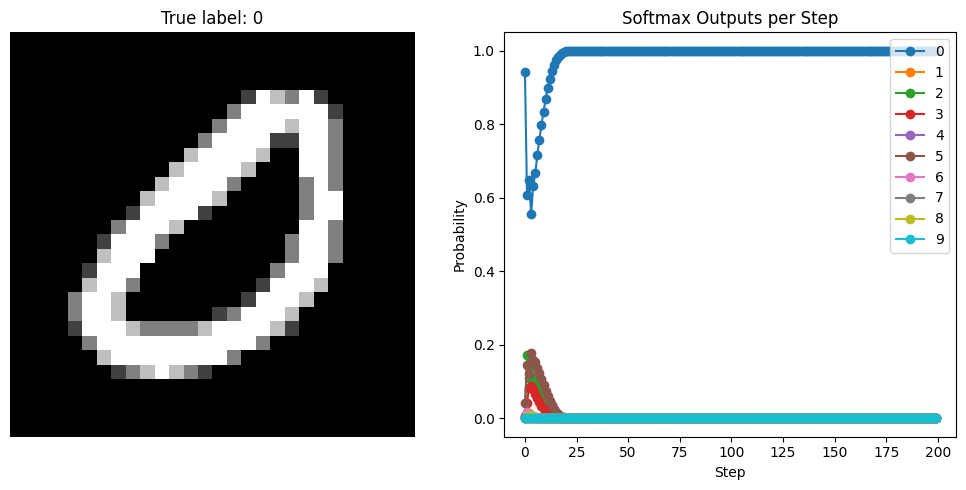

In [ ]:
test_model(model, x_test, y_test, max_steps=200)

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
# Load the MNIST dataset

(x_train, y_train), (x_val, y_val) = mnist.load_data()

# Normalize and reshape the data
x_train = x_train.astype('float32') / 255.0
x_val = x_val.astype('float32') / 255.0

x_train_reshaped = x_train.reshape((-1, 28, 28, 1))
x_val_reshaped = x_val.reshape((-1, 28, 28, 1))

# Convert labels to one-hot encoded format
y_train = to_categorical(y_train, 10)
y_val = to_categorical(y_val, 10)

# Create tf.data.Dataset for both training and validation
BATCH_SIZE = 64
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_reshaped, y_train)).batch(BATCH_SIZE).shuffle(buffer_size=10000).prefetch(tf.data.experimental.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((x_val_reshaped, y_val)).batch(BATCH_SIZE)

11490434/11490434 [==============================] - 2s 0us/step


Epoch 1: Loss: 33.5649, Accuracy: 0.0987
Epoch 2: Loss: 33.3876, Accuracy: 0.0993
Epoch 3: Loss: 33.3876, Accuracy: 0.0970
Epoch 4: Loss: 33.3876, Accuracy: 0.0981
Epoch 5: Loss: 33.3876, Accuracy: 0.0991


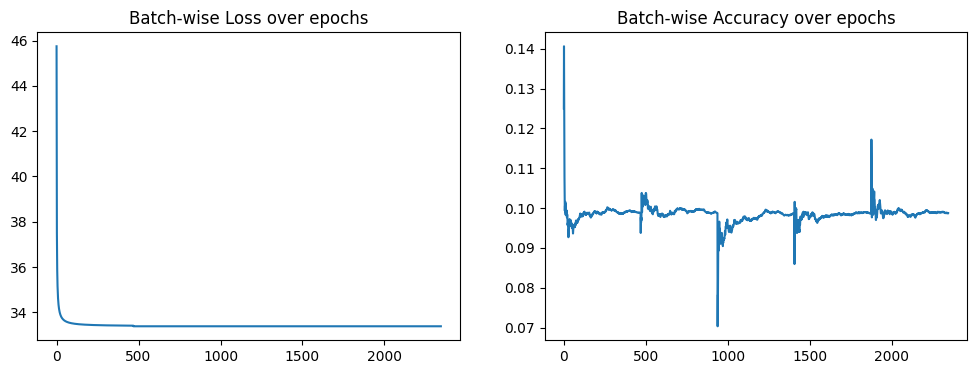

In [ ]:


import numpy as np
import tensorflow as tf

class RecursiveAttentionModel(tf.keras.Model):
    def __init__(self, patch_size, num_hidden, max_iterations=50, lambda_l1=0.01, **kwargs):
        super(RecursiveAttentionModel, self).__init__(**kwargs)
        self.lambda_l1 = lambda_l1  # L1 regularization strength
        self.patch_size = patch_size
        self.num_hidden = num_hidden
        self.num_patches = (28 // patch_size) * (28 // patch_size)
        self.max_iterations = max_iterations

        # Mask to ensure P doesn't get connections from H, S, Y
        mask = np.ones((self.patch_size**2 + num_hidden + self.num_patches + 10,
                                        self.patch_size**2 + num_hidden + self.num_patches + 10), dtype=np.float32)
        np.fill_diagonal(mask, 0)
        mask[:self.patch_size**2 + num_hidden + self.num_patches + 10, :] = 0

        # Define the weight matrix with the mask constraint
        self.W = self.add_weight(shape=(self.patch_size**2 + num_hidden + self.num_patches + 10,
                                        self.patch_size**2 + num_hidden + self.num_patches + 10),
                                 initializer='random_normal',
                                 trainable=True,
                                 constraint=lambda x: x * mask)

    def call(self, inputs):
        # Extract patches from the input image
        patches = tf.image.extract_patches(images=inputs,
                                           sizes=[1, self.patch_size, self.patch_size, 1],
                                           strides=[1, self.patch_size, self.patch_size, 1],
                                           rates=[1, 1, 1, 1],
                                           padding='VALID')

        # Flatten patches
        patches_flattened = tf.reshape(patches, (-1, self.num_patches, self.patch_size**2))

        # Choose the middle patch
        middle_patch_idx = self.num_patches // 2
        middle_patch = patches_flattened[:, middle_patch_idx, :]

        # Initialize S neurons
        initial_S = tf.zeros((tf.shape(inputs)[0], self.num_patches))
        initial_S = tf.tensor_scatter_nd_update(initial_S, [[i, middle_patch_idx] for i in range(tf.shape(inputs)[0])], tf.ones(tf.shape(inputs)[0]))

        # Initial activations
        N = tf.concat([middle_patch,
                       tf.zeros((tf.shape(inputs)[0], self.num_hidden)),
                       initial_S,
                       tf.zeros((tf.shape(inputs)[0], 10))], axis=-1)

        predictions = []

        for _ in range(self.max_iterations):
            N = tf.nn.relu(tf.matmul(N, self.W))

            # Extracting the Y segment from N and apply softmax
            Y = tf.nn.softmax(N[:, -10:])

            # Extracting the S segment from N
            S = N[:, -10-self.num_patches:-10]
            S_onehot = tf.one_hot(tf.argmax(S, axis=1), self.num_patches)

            # Update the P segment of N using S_onehot
            P_selected = tf.reduce_sum(patches_flattened * tf.expand_dims(S_onehot, axis=-1), axis=1)
            N = tf.concat([P_selected, N[:, self.patch_size**2:]], axis=-1)

            predictions.append(Y)

        return tf.stack(predictions, axis=1)

# ... [rest of the code remains unchanged]



# ... [rest of the code remains unchanged]

def train_step(model, inputs, targets, optimizer):
    loss_fn = tf.keras.losses.CategoricalCrossentropy()  # Add this line to define the loss function
    with tf.GradientTape() as tape:
        predictions = model(inputs)

        # Weighted recurrent loss
        weighted_losses = [(i / model.max_iterations + 1) * loss_fn(targets, predictions[:, i]) for i in range(model.max_iterations)]
        recurrent_loss = tf.reduce_sum(weighted_losses)

        # L1 regularization
        l1_loss = model.lambda_l1 * tf.reduce_sum(tf.abs(model.W))

        # Total loss
        total_loss = recurrent_loss + l1_loss

    grads = tape.gradient(total_loss, model.trainable_weights)

    # Gradient clipping
    clip_value = 1.0
    clipped_grads = [tf.clip_by_value(grad, -clip_value, clip_value) for grad in grads]

    optimizer.apply_gradients(zip(clipped_grads, model.trainable_weights))
    return total_loss

# Assuming you have your datasets 'x_train_reshaped', 'y_train', 'x_val_reshaped', and 'y_val' ready

# Create tf.data.Dataset for both training and validation
BATCH_SIZE = 128
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_reshaped, y_train)).batch(BATCH_SIZE).shuffle(buffer_size=10000).prefetch(tf.data.experimental.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((x_val_reshaped, y_val)).batch(BATCH_SIZE)

# Initialize and train the model
optimizer = tf.keras.optimizers.Adam()
model = RecursiveAttentionModel(patch_size=7, num_hidden=100, max_iterations=10)
train_recursive_attention_model(model, train_dataset, val_dataset, optimizer, EPOCHS=5)


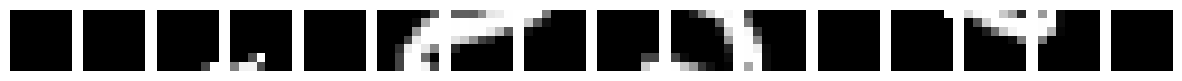

In [ ]:
import matplotlib.pyplot as plt

def visualize_patches(image, patch_size):
    stride = patch_size
    patches = np.array([image[i:i+stride, j:j+stride, 0] for i in range(0, 28, stride) for j in range(0, 28, stride)])

    num_patches = patches.shape[0]

    # Create a grid of subplots
    fig, axs = plt.subplots(1, num_patches, figsize=(15, 15))

    for i in range(num_patches):
        axs[i].imshow(patches[i], cmap='gray')
        axs[i].axis('off')

    plt.show()

image, _ = next(iter(train_dataset))
visualize_patches(image[0].numpy(), model.patch_size)


[9 8 1 0 8 1 0 8 1 0]


<ipython-input-68-8ebd9db9bd58>:43: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(x, y, 'ro-', color='red')  # Ensure it's a red line


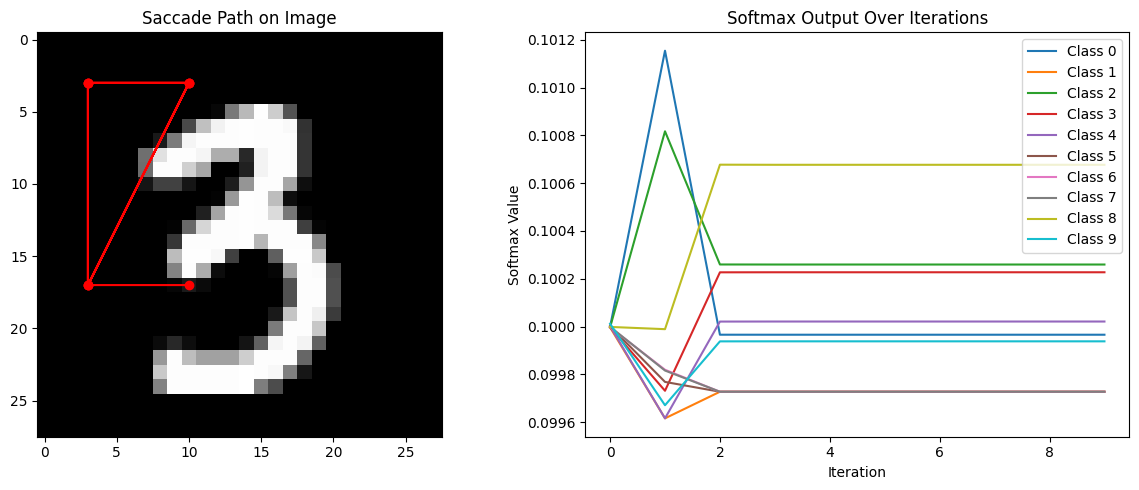

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def inspect_model(model, train_data, patch_size=7, num_steps=None):
    # If num_steps is not provided, use model's max_iterations
    if num_steps is None:
        num_steps = model.max_iterations

    # Randomly select an image from the training data
    img, label = next(iter(train_data.shuffle(1000).take(1)))
    img = np.squeeze(img.numpy())

    # Reshape img to ensure it has 4 dimensions
    img_reshaped = tf.reshape(img, (-1, 28, 28, 1))

    # Get the model predictions (here, you'd need to modify your model to accept the num_steps parameter)
    model.max_iterations=num_steps
    predictions = model(img_reshaped)

    # Extract saccade positions
    saccades = predictions[1].numpy()

    if len(saccades.shape) > 2:  # Ensure we handle both batched and unbatched predictions
        saccade_positions = np.argmax(saccades[0], axis=1)
    else:
        saccade_positions = np.argmax(saccades, axis=1)
    print(saccade_positions)
    # Calculate the center of the selected patch
    patch_centers = [(i // (28 // patch_size) * patch_size + patch_size // 2,
                      i % (28 // patch_size) * patch_size + patch_size // 2)
                     for i in saccade_positions]

    # Plotting
    plt.figure(figsize=(12, 5))

    # Left plot: Image with saccade path
    plt.subplot(1, 2, 1)
    plt.imshow(np.squeeze(img_reshaped[0]), cmap='gray')  # Take the first image in the batch

    # Draw saccade path
    if patch_centers:
        y, x = zip(*patch_centers)
        plt.plot(x, y, 'ro-', color='red')  # Ensure it's a red line

    plt.title("Saccade Path on Image")

    # Right plot: Softmax outputs
    plt.subplot(1, 2, 2)
    softmax_vals = predictions[0].numpy()
    if len(softmax_vals.shape) > 2:
        softmax_vals = softmax_vals[0]
    for i in range(10):
        plt.plot(softmax_vals[:, i], label=f"Class {i}")

    plt.title("Softmax Output Over Iterations")
    plt.xlabel("Iteration")
    plt.ylabel("Softmax Value")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Inspect the model for a specific number of steps
inspect_model(model, train_dataset, num_steps=10)
